##### Copyright 2018 The AdaNet Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Customizing AdaNet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


Often times, as a researcher or machine learning practitioner, you will have
some prior knowledge about a dataset. Ideally you should be able to encode that
knowledge into your machine learning algorithm. With `adanet`, you can do so by
defining the *neural architecture search space* that the AdaNet algorithm should
explore.

In this tutorial, we will explore the flexibility of the `adanet` framework, and
create a custom search space for an image-classification dataset using high-level
TensorFlow libraries like the
[`tf.keras.layers`](https://www.tensorflow.org/guide/keras#build_advanced_models)
functional API.



In [2]:
#@test {"skip": true}
# If you're running this in Colab, first install the adanet package:
!pip install adanet

     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 163kB 8.6MB/s 
     |████████████████████████████████| 215kB 49.4MB/s 
  Created wheel for rednose: filename=rednose-1.3.0-cp36-none-any.whl size=12155 sha256=4a499251deaec6c7adfa222e583b7baf3f508a2b3c95db792f3def0fd2e2db34
  Stored in directory: /root/.cache/pip/wheels/21/be/74/e74fbccdaf7ab983f847153b2708e4d1722801ce7265dfa643
  Created wheel for termstyle: filename=termstyle-0.1.11-cp36-none-any.whl size=4778 sha256=1d175ec8628584ad81710cb35040e6cbd6b25d3d5aae0fba644840a8f58fc446
  Stored in directory: /root/.cache/pip/wheels/93/0c/cf/1d134a42237c338ee1d733c81b92d95f6d04d9531bf4c2a9a1
Successfully built rednose termstyle
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import os
import shutil

import adanet
from adanet.examples import simple_dnn
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf


# The random seed to use.
RANDOM_SEED = 42

LOG_DIR = '/tmp/models'

## Fashion MNIST dataset

In this example, we will use the Fashion MNIST dataset
[[Xiao et al., 2017](https://arxiv.org/abs/1708.07747)] for classifying fashion
apparel images into one of ten categories:

1.  T-shirt/top
2.  Trouser
3.  Pullover
4.  Dress
5.  Coat
6.  Sandal
7.  Shirt
8.  Sneaker
9.  Bag
10. Ankle boot

![Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

## Download the data

Conveniently, the data is available via Keras:

In [4]:
(x_train, y_train), (x_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data())

4423680/4422102 [==============================] - 0s 0us/step


## Supply the data in TensorFlow

Our first task is to supply the data in TensorFlow. Using the
tf.estimator.Estimator covention, we will define a function that returns an
`input_fn` which returns feature and label `Tensors`.

We will also use the `tf.data.Dataset` API to feed the data into our models.

In [0]:
FEATURES_KEY = "images"


def generator(images, labels):
  """Returns a generator that returns image-label pairs."""

  def _gen():
    for image, label in zip(images, labels):
      yield image, label

  return _gen


def preprocess_image(image, label):
  """Preprocesses an image for an `Estimator`."""
  # First let's scale the pixel values to be between 0 and 1.
  image = image / 255.
  # Next we reshape the image so that we can apply a 2D convolution to it.
  image = tf.reshape(image, [28, 28, 1])
  # Finally the features need to be supplied as a dictionary.
  features = {FEATURES_KEY: image}
  return features, label


def input_fn(partition, training, batch_size):
  """Generate an input_fn for the Estimator."""

  def _input_fn():
    if partition == "train":
      dataset = tf.data.Dataset.from_generator(
          generator(x_train, y_train), (tf.float32, tf.int32), ((28, 28), ()))
    elif partition == "predict":
      dataset = tf.data.Dataset.from_generator(
          generator(x_test[:10], y_test[:10]), (tf.float32, tf.int32), ((28,28), ()))
    else:
      dataset = tf.data.Dataset.from_generator(
          generator(x_test, y_test), (tf.float32, tf.int32), ((28, 28), ()))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    if training:
      dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()

    dataset = dataset.map(preprocess_image).batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

  return _input_fn

## Launch TensorBoard

Let's run [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) to visualize model training over time. We'll use [ngrok](https://ngrok.com/) to tunnel traffic to localhost.

*The instructions for setting up Tensorboard were obtained from https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/*

Run the next cells and follow the link to see the TensorBoard in a new tab.

In [6]:
#@test {"skip": true}

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# Install ngrok binary.
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

# Delete old logs dir.
shutil.rmtree(LOG_DIR, ignore_errors=True)

print("Follow this link to open TensorBoard in a new tab.")
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



--2020-01-28 23:24:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.238.36.128, 34.193.139.214, 34.206.126.139, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.238.36.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.62MB/s    in 2.0s    

2020-01-28 23:24:15 (6.62 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Follow this link to open TensorBoard in a new tab.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Establish baselines

The next task should be to get somes baselines to see how our model performs on
this dataset.

Let's define some information to share with all our `tf.estimator.Estimators`:

In [0]:
# The number of classes.
NUM_CLASSES = 10

# A `Head` instance defines the loss function and metrics for `Estimators`.
head = tf.estimator.MultiClassHead(NUM_CLASSES)

# Some `Estimators` use feature columns for understanding their input features.
feature_columns = [
    tf.feature_column.numeric_column(FEATURES_KEY, shape=[28, 28, 1])
]

def make_config(experiment_name):
  # Estimator configuration.
  return tf.estimator.RunConfig(
    save_checkpoints_steps=1000,
    save_summary_steps=1000,
    tf_random_seed=RANDOM_SEED,
    model_dir=os.path.join(LOG_DIR, experiment_name))

Let's start simple, and train a linear model:

In [8]:
#@test {"skip": true}
#@title Parameters
LEARNING_RATE = 0.001  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}

estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=NUM_CLASSES,
    optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE),
    config=make_config("linear"))

tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None,
        start_delay_secs=1,
        throttle_secs=1,  
    ))
results = estimator.evaluate(
    input_fn("test", training=False, batch_size=BATCH_SIZE),
    steps=None)
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/linear', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b1c3ec080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evalu

The linear model with default parameters achieves about **84.14% accuracy**.

Let's see if we can do better with the `simple_dnn` AdaNet:

In [9]:
#@test {"skip": true}
#@title Parameters
LEARNING_RATE = 0.003  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}
ADANET_ITERATIONS = 2  #@param {type:"integer"}

estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=simple_dnn.Generator(
        feature_columns=feature_columns,
        optimizer=tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE),
        seed=RANDOM_SEED),
    max_iteration_steps=TRAIN_STEPS // ADANET_ITERATIONS,
    evaluator=adanet.Evaluator(
        input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE),
        steps=None),
    config=make_config("simple_dnn"))

tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None,
        start_delay_secs=1,
        throttle_secs=1,  
    ))

results = estimator.evaluate(
    input_fn("test", training=False, batch_size=BATCH_SIZE),
    steps=None)
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0cfd1a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and e

INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0cfd1e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use keras.layers.dropout instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:loss = 2.603788, step = 0


INFO:tensorflow:loss = 2.603788, step = 0


INFO:tensorflow:global_step/sec: 58.0022


INFO:tensorflow:global_step/sec: 58.0022


INFO:tensorflow:loss = 0.8165605, step = 100 (1.741 sec)


INFO:tensorflow:loss = 0.8165605, step = 100 (1.741 sec)


INFO:tensorflow:global_step/sec: 68.515


INFO:tensorflow:global_step/sec: 68.515


INFO:tensorflow:loss = 0.66095746, step = 200 (1.446 sec)


INFO:tensorflow:loss = 0.66095746, step = 200 (1.446 sec)


INFO:tensorflow:global_step/sec: 68.2362


INFO:tensorflow:global_step/sec: 68.2362


INFO:tensorflow:loss = 0.38084134, step = 300 (1.470 sec)


INFO:tensorflow:loss = 0.38084134, step = 300 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.5841


INFO:tensorflow:global_step/sec: 68.5841


INFO:tensorflow:loss = 0.49972004, step = 400 (1.452 sec)


INFO:tensorflow:loss = 0.49972004, step = 400 (1.452 sec)


INFO:tensorflow:global_step/sec: 66.1803


INFO:tensorflow:global_step/sec: 66.1803


INFO:tensorflow:loss = 0.4046151, step = 500 (1.511 sec)


INFO:tensorflow:loss = 0.4046151, step = 500 (1.511 sec)


INFO:tensorflow:global_step/sec: 68.5868


INFO:tensorflow:global_step/sec: 68.5868


INFO:tensorflow:loss = 0.8298083, step = 600 (1.461 sec)


INFO:tensorflow:loss = 0.8298083, step = 600 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.7415


INFO:tensorflow:global_step/sec: 66.7415


INFO:tensorflow:loss = 0.47103176, step = 700 (1.496 sec)


INFO:tensorflow:loss = 0.47103176, step = 700 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.2163


INFO:tensorflow:global_step/sec: 68.2163


INFO:tensorflow:loss = 0.6030396, step = 800 (1.469 sec)


INFO:tensorflow:loss = 0.6030396, step = 800 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.0853


INFO:tensorflow:global_step/sec: 68.0853


INFO:tensorflow:loss = 0.2797109, step = 900 (1.465 sec)


INFO:tensorflow:loss = 0.2797109, step = 900 (1.465 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-1000


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b041ddb70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b041ddb70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:26:21Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:26:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:26:25


INFO:tensorflow:Finished evaluation at 2020-01-28-23:26:25


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8222, average_loss = 0.50020385, best_ensemble_index_0 = 1, global_step = 1000, iteration = 0, loss = 0.4996074


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8222, average_loss = 0.50020385, best_ensemble_index_0 = 1, global_step = 1000, iteration = 0, loss = 0.4996074


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/models/simple_dnn/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/models/simple_dnn/model.ckpt-1000


INFO:tensorflow:global_step/sec: 4.73282


INFO:tensorflow:global_step/sec: 4.73282


INFO:tensorflow:loss = 0.4469478, step = 1000 (21.128 sec)


INFO:tensorflow:loss = 0.4469478, step = 1000 (21.128 sec)


INFO:tensorflow:global_step/sec: 69.1939


INFO:tensorflow:global_step/sec: 69.1939


INFO:tensorflow:loss = 0.49168974, step = 1100 (1.453 sec)


INFO:tensorflow:loss = 0.49168974, step = 1100 (1.453 sec)


INFO:tensorflow:global_step/sec: 66.7079


INFO:tensorflow:global_step/sec: 66.7079


INFO:tensorflow:loss = 0.59497625, step = 1200 (1.493 sec)


INFO:tensorflow:loss = 0.59497625, step = 1200 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.1564


INFO:tensorflow:global_step/sec: 68.1564


INFO:tensorflow:loss = 0.35278708, step = 1300 (1.472 sec)


INFO:tensorflow:loss = 0.35278708, step = 1300 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.3813


INFO:tensorflow:global_step/sec: 65.3813


INFO:tensorflow:loss = 0.50315446, step = 1400 (1.530 sec)


INFO:tensorflow:loss = 0.50315446, step = 1400 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.0373


INFO:tensorflow:global_step/sec: 66.0373


INFO:tensorflow:loss = 0.3651929, step = 1500 (1.507 sec)


INFO:tensorflow:loss = 0.3651929, step = 1500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.993


INFO:tensorflow:global_step/sec: 66.993


INFO:tensorflow:loss = 0.25101003, step = 1600 (1.497 sec)


INFO:tensorflow:loss = 0.25101003, step = 1600 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1637


INFO:tensorflow:global_step/sec: 67.1637


INFO:tensorflow:loss = 0.493657, step = 1700 (1.484 sec)


INFO:tensorflow:loss = 0.493657, step = 1700 (1.484 sec)


INFO:tensorflow:global_step/sec: 69.4439


INFO:tensorflow:global_step/sec: 69.4439


INFO:tensorflow:loss = 0.40216514, step = 1800 (1.440 sec)


INFO:tensorflow:loss = 0.40216514, step = 1800 (1.440 sec)


INFO:tensorflow:global_step/sec: 68.2726


INFO:tensorflow:global_step/sec: 68.2726


INFO:tensorflow:loss = 0.41076538, step = 1900 (1.464 sec)


INFO:tensorflow:loss = 0.41076538, step = 1900 (1.464 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04009e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04009e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:26:55Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:26:55Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:26:58


INFO:tensorflow:Finished evaluation at 2020-01-28-23:26:58


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8533, average_loss = 0.41756538, best_ensemble_index_0 = 1, global_step = 2000, iteration = 0, loss = 0.41665503


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8533, average_loss = 0.41756538, best_ensemble_index_0 = 1, global_step = 2000, iteration = 0, loss = 0.41665503


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/models/simple_dnn/model.ckpt-2000


INFO:tensorflow:global_step/sec: 5.11941


INFO:tensorflow:global_step/sec: 5.11941


INFO:tensorflow:loss = 0.48366874, step = 2000 (19.533 sec)


INFO:tensorflow:loss = 0.48366874, step = 2000 (19.533 sec)


INFO:tensorflow:global_step/sec: 67.4132


INFO:tensorflow:global_step/sec: 67.4132


INFO:tensorflow:loss = 0.4200433, step = 2100 (1.485 sec)


INFO:tensorflow:loss = 0.4200433, step = 2100 (1.485 sec)


INFO:tensorflow:global_step/sec: 64.9966


INFO:tensorflow:global_step/sec: 64.9966


INFO:tensorflow:loss = 0.2366377, step = 2200 (1.543 sec)


INFO:tensorflow:loss = 0.2366377, step = 2200 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.8132


INFO:tensorflow:global_step/sec: 66.8132


INFO:tensorflow:loss = 0.25099033, step = 2300 (1.494 sec)


INFO:tensorflow:loss = 0.25099033, step = 2300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.8192


INFO:tensorflow:global_step/sec: 67.8192


INFO:tensorflow:loss = 0.2939929, step = 2400 (1.480 sec)


INFO:tensorflow:loss = 0.2939929, step = 2400 (1.480 sec)


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03125828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03125828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:27:21Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:27:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:27:24


INFO:tensorflow:Finished evaluation at 2020-01-28-23:27:24


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.8506, average_loss = 0.42281744, best_ensemble_index_0 = 1, global_step = 2500, iteration = 0, loss = 0.42212486


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.8506, average_loss = 0.42281744, best_ensemble_index_0 = 1, global_step = 2500, iteration = 0, loss = 0.42212486


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Loss for final step: 0.30081838.


INFO:tensorflow:Loss for final step: 0.30081838.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn/temp_model_dir/1580254058504', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0c97a278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn/temp_model_dir/1580254058504', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0c97a278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_dnn/temp_model_dir/1580254058504/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_dnn/temp_model_dir/1580254058504/model.ckpt.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-2500


INFO:tensorflow:Saving checkpoints for 2501 into /tmp/models/simple_dnn/temp_model_dir/1580254058504/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2501 into /tmp/models/simple_dnn/temp_model_dir/1580254058504/model.ckpt.


INFO:tensorflow:loss = 0.31168938, step = 2501


INFO:tensorflow:loss = 0.31168938, step = 2501


INFO:tensorflow:Loss for final step: 0.31168938.


INFO:tensorflow:Loss for final step: 0.31168938.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b05bfd978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b05bfd978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:loss = 0.31168938, step = 2500


INFO:tensorflow:loss = 0.31168938, step = 2500


INFO:tensorflow:global_step/sec: 54.6787


INFO:tensorflow:global_step/sec: 54.6787


INFO:tensorflow:loss = 0.17422614, step = 2600 (1.841 sec)


INFO:tensorflow:loss = 0.17422614, step = 2600 (1.841 sec)


INFO:tensorflow:global_step/sec: 66.6588


INFO:tensorflow:global_step/sec: 66.6588


INFO:tensorflow:loss = 0.5036852, step = 2700 (1.495 sec)


INFO:tensorflow:loss = 0.5036852, step = 2700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.1429


INFO:tensorflow:global_step/sec: 65.1429


INFO:tensorflow:loss = 0.27954224, step = 2800 (1.539 sec)


INFO:tensorflow:loss = 0.27954224, step = 2800 (1.539 sec)


INFO:tensorflow:global_step/sec: 69.1591


INFO:tensorflow:global_step/sec: 69.1591


INFO:tensorflow:loss = 0.39685076, step = 2900 (1.443 sec)


INFO:tensorflow:loss = 0.39685076, step = 2900 (1.443 sec)


INFO:tensorflow:global_step/sec: 68.5735


INFO:tensorflow:global_step/sec: 68.5735


INFO:tensorflow:loss = 0.27495292, step = 3000 (1.454 sec)


INFO:tensorflow:loss = 0.27495292, step = 3000 (1.454 sec)


INFO:tensorflow:global_step/sec: 65.6816


INFO:tensorflow:global_step/sec: 65.6816


INFO:tensorflow:loss = 0.50383085, step = 3100 (1.523 sec)


INFO:tensorflow:loss = 0.50383085, step = 3100 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.5642


INFO:tensorflow:global_step/sec: 67.5642


INFO:tensorflow:loss = 0.44185284, step = 3200 (1.483 sec)


INFO:tensorflow:loss = 0.44185284, step = 3200 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.5454


INFO:tensorflow:global_step/sec: 65.5454


INFO:tensorflow:loss = 0.450566, step = 3300 (1.525 sec)


INFO:tensorflow:loss = 0.450566, step = 3300 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2342


INFO:tensorflow:global_step/sec: 66.2342


INFO:tensorflow:loss = 0.2405195, step = 3400 (1.511 sec)


INFO:tensorflow:loss = 0.2405195, step = 3400 (1.511 sec)


INFO:tensorflow:Saving checkpoints for 3500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:global_step/sec: 47.5938


INFO:tensorflow:global_step/sec: 47.5938


INFO:tensorflow:loss = 0.38556522, step = 3500 (2.099 sec)


INFO:tensorflow:loss = 0.38556522, step = 3500 (2.099 sec)


INFO:tensorflow:global_step/sec: 69.4946


INFO:tensorflow:global_step/sec: 69.4946


INFO:tensorflow:loss = 0.34398308, step = 3600 (1.437 sec)


INFO:tensorflow:loss = 0.34398308, step = 3600 (1.437 sec)


INFO:tensorflow:global_step/sec: 67.633


INFO:tensorflow:global_step/sec: 67.633


INFO:tensorflow:loss = 0.6122652, step = 3700 (1.481 sec)


INFO:tensorflow:loss = 0.6122652, step = 3700 (1.481 sec)


INFO:tensorflow:global_step/sec: 64.7956


INFO:tensorflow:global_step/sec: 64.7956


INFO:tensorflow:loss = 0.2923677, step = 3800 (1.544 sec)


INFO:tensorflow:loss = 0.2923677, step = 3800 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.1339


INFO:tensorflow:global_step/sec: 67.1339


INFO:tensorflow:loss = 0.43072838, step = 3900 (1.491 sec)


INFO:tensorflow:loss = 0.43072838, step = 3900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2459


INFO:tensorflow:global_step/sec: 66.2459


INFO:tensorflow:loss = 0.38637918, step = 4000 (1.509 sec)


INFO:tensorflow:loss = 0.38637918, step = 4000 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.2186


INFO:tensorflow:global_step/sec: 64.2186


INFO:tensorflow:loss = 0.19899742, step = 4100 (1.564 sec)


INFO:tensorflow:loss = 0.19899742, step = 4100 (1.564 sec)


INFO:tensorflow:global_step/sec: 65.458


INFO:tensorflow:global_step/sec: 65.458


INFO:tensorflow:loss = 0.3459694, step = 4200 (1.520 sec)


INFO:tensorflow:loss = 0.3459694, step = 4200 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7555


INFO:tensorflow:global_step/sec: 65.7555


INFO:tensorflow:loss = 0.41656035, step = 4300 (1.531 sec)


INFO:tensorflow:loss = 0.41656035, step = 4300 (1.531 sec)


INFO:tensorflow:global_step/sec: 64.6976


INFO:tensorflow:global_step/sec: 64.6976


INFO:tensorflow:loss = 0.34805182, step = 4400 (1.535 sec)


INFO:tensorflow:loss = 0.34805182, step = 4400 (1.535 sec)


INFO:tensorflow:Saving checkpoints for 4500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4500 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:global_step/sec: 58.2602


INFO:tensorflow:global_step/sec: 58.2602


INFO:tensorflow:loss = 0.42429283, step = 4500 (1.711 sec)


INFO:tensorflow:loss = 0.42429283, step = 4500 (1.711 sec)


INFO:tensorflow:global_step/sec: 66.7339


INFO:tensorflow:global_step/sec: 66.7339


INFO:tensorflow:loss = 0.37127605, step = 4600 (1.502 sec)


INFO:tensorflow:loss = 0.37127605, step = 4600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.3439


INFO:tensorflow:global_step/sec: 66.3439


INFO:tensorflow:loss = 0.20735526, step = 4700 (1.505 sec)


INFO:tensorflow:loss = 0.20735526, step = 4700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7549


INFO:tensorflow:global_step/sec: 66.7549


INFO:tensorflow:loss = 0.19874632, step = 4800 (1.503 sec)


INFO:tensorflow:loss = 0.19874632, step = 4800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6383


INFO:tensorflow:global_step/sec: 66.6383


INFO:tensorflow:loss = 0.18172987, step = 4900 (1.502 sec)


INFO:tensorflow:loss = 0.18172987, step = 4900 (1.502 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/models/simple_dnn/model.ckpt.


INFO:tensorflow:Loss for final step: 0.20381317.


INFO:tensorflow:Loss for final step: 0.20381317.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-5000


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03b80e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_dnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03b80e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:28:43Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:28:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_dnn/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:28:47


INFO:tensorflow:Finished evaluation at 2020-01-28-23:28:47


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.8564, average_loss = 0.40214804, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 5000, iteration = 1, loss = 0.4015974


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.8564, average_loss = 0.40214804, best_ensemble_index_0 = 1, best_ensemble_index_1 = 2, global_step = 5000, iteration = 1, loss = 0.4015974


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/models/simple_dnn/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/models/simple_dnn/model.ckpt-5000


Accuracy: 0.8564
Loss: 0.40214804


The `simple_dnn` AdaNet model with default parameters achieves about **85.64%
accuracy**.

This improvement can be attributed to `simple_dnn` searching over
fully-connected neural networks which have more expressive power than the linear
model due to their non-linear activations.

Fully-connected layers are permutation invariant to their inputs, meaning that
if we consistently swapped two pixels before training, the final model would
perform identically. However, there is spatial and locality information in
images that we should try to capture. Applying a few convolutions to our inputs
will allow us to do so, and that will require defining a custom
`adanet.subnetwork.Builder` and `adanet.subnetwork.Generator`.

## Define a convolutional AdaNet model

Creating a new search space for AdaNet to explore is straightforward. There are
two abstract classes you need to extend:

1.  `adanet.subnetwork.Builder`
2.  `adanet.subnetwork.Generator`

Similar to the tf.estimator.Estimator `model_fn`, `adanet.subnetwork.Builder`
allows you to define your own TensorFlow graph for creating a neural network,
and specify the training operations.

Below we define one that applies a 2D convolution, max-pooling, and then a
fully-connected layer to the images:

In [0]:
class SimpleCNNBuilder(adanet.subnetwork.Builder):
  """Builds a CNN subnetwork for AdaNet."""

  def __init__(self, learning_rate, max_iteration_steps, seed):
    """Initializes a `SimpleCNNBuilder`.

    Args:
      learning_rate: The float learning rate to use.
      max_iteration_steps: The number of steps per iteration.
      seed: The random seed.

    Returns:
      An instance of `SimpleCNNBuilder`.
    """
    self._learning_rate = learning_rate
    self._max_iteration_steps = max_iteration_steps
    self._seed = seed

  def build_subnetwork(self,
                       features,
                       logits_dimension,
                       training,
                       iteration_step,
                       summary,
                       previous_ensemble=None):
    """See `adanet.subnetwork.Builder`."""
    images = list(features.values())[0]
    
    # Visualize some of the input images in TensorBoard.
    summary.image("images", images)
    
    kernel_initializer = tf.keras.initializers.he_normal(seed=self._seed)
    x = tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer=kernel_initializer)(
            images)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        units=64, activation="relu", kernel_initializer=kernel_initializer)(
            x)

    # The `Head` passed to adanet.Estimator will apply the softmax activation.
    logits = tf.keras.layers.Dense(
        units=10, activation=None, kernel_initializer=kernel_initializer)(
            x)

    # Use a constant complexity measure, since all subnetworks have the same
    # architecture and hyperparameters.
    complexity = tf.constant(1)

    return adanet.Subnetwork(
        last_layer=x,
        logits=logits,
        complexity=complexity,
        persisted_tensors={})

  def build_subnetwork_train_op(self,
                                subnetwork,
                                loss,
                                var_list,
                                labels,
                                iteration_step,
                                summary,
                                previous_ensemble=None):
    """See `adanet.subnetwork.Builder`."""

    # Momentum optimizer with cosine learning rate decay works well with CNNs.
    learning_rate = tf.train.cosine_decay(
        learning_rate=self._learning_rate,
        global_step=iteration_step,
        decay_steps=self._max_iteration_steps)
    optimizer = tf.train.MomentumOptimizer(learning_rate, .9)
    # NOTE: The `adanet.Estimator` increments the global step.
    return optimizer.minimize(loss=loss, var_list=var_list)

  def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):
    """See `adanet.subnetwork.Builder`."""
    return tf.no_op("mixture_weights_train_op")

  @property
  def name(self):
    """See `adanet.subnetwork.Builder`."""
    return "simple_cnn"

Next, we extend a `adanet.subnetwork.Generator`, which defines the search
space of candidate `SimpleCNNBuilders` to consider including the final network.
It can create one or more at each iteration with different parameters, and the
AdaNet algorithm will select the candidate that best improves the overall neural
network's `adanet_loss` on the training set.

The one below is very simple: it always creates the same architecture, but gives
it a different random seed at each iteration:

In [0]:
class SimpleCNNGenerator(adanet.subnetwork.Generator):
  """Generates a `SimpleCNN` at each iteration.
  """

  def __init__(self, learning_rate, max_iteration_steps, seed=None):
    """Initializes a `Generator` that builds `SimpleCNNs`.

    Args:
      learning_rate: The float learning rate to use.
      max_iteration_steps: The number of steps per iteration.
      seed: The random seed.

    Returns:
      An instance of `Generator`.
    """
    self._seed = seed
    self._dnn_builder_fn = functools.partial(
        SimpleCNNBuilder,
        learning_rate=learning_rate,
        max_iteration_steps=max_iteration_steps)

  def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
    """See `adanet.subnetwork.Generator`."""
    seed = self._seed
    # Change the seed according to the iteration so that each subnetwork
    # learns something different.
    if seed is not None:
      seed += iteration_number
    return [self._dnn_builder_fn(seed=seed)]

With these defined, we pass them into a new `adanet.Estimator`:

In [12]:
#@title Parameters
LEARNING_RATE = 0.05  #@param {type:"number"}
TRAIN_STEPS = 5000  #@param {type:"integer"}
BATCH_SIZE = 64  #@param {type:"integer"}
ADANET_ITERATIONS = 2  #@param {type:"integer"}

max_iteration_steps = TRAIN_STEPS // ADANET_ITERATIONS
estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=SimpleCNNGenerator(
        learning_rate=LEARNING_RATE,
        max_iteration_steps=max_iteration_steps,
        seed=RANDOM_SEED),
    max_iteration_steps=max_iteration_steps,
    evaluator=adanet.Evaluator(
        input_fn=input_fn("train", training=False, batch_size=BATCH_SIZE),
        steps=None),
    adanet_loss_decay=.99,
    config=make_config("simple_cnn"))

results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None,
        start_delay_secs=1,
        throttle_secs=1,  
    ))
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])

INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04fad668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04fad668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04fadc88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04fadc88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
`persisted_tensors` is deprecated, please use `shared` instead.


Instructions for updating:
`persisted_tensors` is deprecated, please use `shared` instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:loss = 2.7829337, step = 0


INFO:tensorflow:loss = 2.7829337, step = 0


INFO:tensorflow:global_step/sec: 34.8672


INFO:tensorflow:global_step/sec: 34.8672


INFO:tensorflow:loss = 0.37638825, step = 100 (2.870 sec)


INFO:tensorflow:loss = 0.37638825, step = 100 (2.870 sec)


INFO:tensorflow:global_step/sec: 35.4227


INFO:tensorflow:global_step/sec: 35.4227


INFO:tensorflow:loss = 0.5209242, step = 200 (2.824 sec)


INFO:tensorflow:loss = 0.5209242, step = 200 (2.824 sec)


INFO:tensorflow:global_step/sec: 36.8113


INFO:tensorflow:global_step/sec: 36.8113


INFO:tensorflow:loss = 0.27607995, step = 300 (2.716 sec)


INFO:tensorflow:loss = 0.27607995, step = 300 (2.716 sec)


INFO:tensorflow:global_step/sec: 35.5856


INFO:tensorflow:global_step/sec: 35.5856


INFO:tensorflow:loss = 0.3605134, step = 400 (2.810 sec)


INFO:tensorflow:loss = 0.3605134, step = 400 (2.810 sec)


INFO:tensorflow:global_step/sec: 37.8285


INFO:tensorflow:global_step/sec: 37.8285


INFO:tensorflow:loss = 0.2832445, step = 500 (2.646 sec)


INFO:tensorflow:loss = 0.2832445, step = 500 (2.646 sec)


INFO:tensorflow:global_step/sec: 37.0919


INFO:tensorflow:global_step/sec: 37.0919


INFO:tensorflow:loss = 0.40479934, step = 600 (2.693 sec)


INFO:tensorflow:loss = 0.40479934, step = 600 (2.693 sec)


INFO:tensorflow:global_step/sec: 36.8642


INFO:tensorflow:global_step/sec: 36.8642


INFO:tensorflow:loss = 0.43839163, step = 700 (2.715 sec)


INFO:tensorflow:loss = 0.43839163, step = 700 (2.715 sec)


INFO:tensorflow:global_step/sec: 37.4738


INFO:tensorflow:global_step/sec: 37.4738


INFO:tensorflow:loss = 0.37346122, step = 800 (2.666 sec)


INFO:tensorflow:loss = 0.37346122, step = 800 (2.666 sec)


INFO:tensorflow:global_step/sec: 36.9895


INFO:tensorflow:global_step/sec: 36.9895


INFO:tensorflow:loss = 0.12023185, step = 900 (2.705 sec)


INFO:tensorflow:loss = 0.12023185, step = 900 (2.705 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04d81a20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04d81a20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:29:18Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:29:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:29:21


INFO:tensorflow:Finished evaluation at 2020-01-28-23:29:21


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8816, average_loss = 0.33634645, best_ensemble_index_0 = 0, global_step = 1000, iteration = 0, loss = 0.3361071


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8816, average_loss = 0.33634645, best_ensemble_index_0 = 0, global_step = 1000, iteration = 0, loss = 0.3361071


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/models/simple_cnn/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/models/simple_cnn/model.ckpt-1000


INFO:tensorflow:global_step/sec: 12.6757


INFO:tensorflow:global_step/sec: 12.6757


INFO:tensorflow:loss = 0.33306035, step = 1000 (7.889 sec)


INFO:tensorflow:loss = 0.33306035, step = 1000 (7.889 sec)


INFO:tensorflow:global_step/sec: 36.7901


INFO:tensorflow:global_step/sec: 36.7901


INFO:tensorflow:loss = 0.26332143, step = 1100 (2.718 sec)


INFO:tensorflow:loss = 0.26332143, step = 1100 (2.718 sec)


INFO:tensorflow:global_step/sec: 38.053


INFO:tensorflow:global_step/sec: 38.053


INFO:tensorflow:loss = 0.5548452, step = 1200 (2.628 sec)


INFO:tensorflow:loss = 0.5548452, step = 1200 (2.628 sec)


INFO:tensorflow:global_step/sec: 37.1053


INFO:tensorflow:global_step/sec: 37.1053


INFO:tensorflow:loss = 0.3751756, step = 1300 (2.695 sec)


INFO:tensorflow:loss = 0.3751756, step = 1300 (2.695 sec)


INFO:tensorflow:global_step/sec: 38.2062


INFO:tensorflow:global_step/sec: 38.2062


INFO:tensorflow:loss = 0.40759182, step = 1400 (2.617 sec)


INFO:tensorflow:loss = 0.40759182, step = 1400 (2.617 sec)


INFO:tensorflow:global_step/sec: 35.6691


INFO:tensorflow:global_step/sec: 35.6691


INFO:tensorflow:loss = 0.43741018, step = 1500 (2.809 sec)


INFO:tensorflow:loss = 0.43741018, step = 1500 (2.809 sec)


INFO:tensorflow:global_step/sec: 36.6863


INFO:tensorflow:global_step/sec: 36.6863


INFO:tensorflow:loss = 0.11292698, step = 1600 (2.722 sec)


INFO:tensorflow:loss = 0.11292698, step = 1600 (2.722 sec)


INFO:tensorflow:global_step/sec: 36.7414


INFO:tensorflow:global_step/sec: 36.7414


INFO:tensorflow:loss = 0.28705102, step = 1700 (2.722 sec)


INFO:tensorflow:loss = 0.28705102, step = 1700 (2.722 sec)


INFO:tensorflow:global_step/sec: 37.8563


INFO:tensorflow:global_step/sec: 37.8563


INFO:tensorflow:loss = 0.38228264, step = 1800 (2.644 sec)


INFO:tensorflow:loss = 0.38228264, step = 1800 (2.644 sec)


INFO:tensorflow:global_step/sec: 37.3185


INFO:tensorflow:global_step/sec: 37.3185


INFO:tensorflow:loss = 0.20412554, step = 1900 (2.675 sec)


INFO:tensorflow:loss = 0.20412554, step = 1900 (2.675 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b031c36a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b031c36a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:29:50Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:29:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:29:54


INFO:tensorflow:Finished evaluation at 2020-01-28-23:29:54


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8943, average_loss = 0.2866584, best_ensemble_index_0 = 0, global_step = 2000, iteration = 0, loss = 0.28647542


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8943, average_loss = 0.2866584, best_ensemble_index_0 = 0, global_step = 2000, iteration = 0, loss = 0.28647542


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/models/simple_cnn/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/models/simple_cnn/model.ckpt-2000


INFO:tensorflow:global_step/sec: 12.5854


INFO:tensorflow:global_step/sec: 12.5854


INFO:tensorflow:loss = 0.25820497, step = 2000 (7.947 sec)


INFO:tensorflow:loss = 0.25820497, step = 2000 (7.947 sec)


INFO:tensorflow:global_step/sec: 36.7172


INFO:tensorflow:global_step/sec: 36.7172


INFO:tensorflow:loss = 0.19789831, step = 2100 (2.723 sec)


INFO:tensorflow:loss = 0.19789831, step = 2100 (2.723 sec)


INFO:tensorflow:global_step/sec: 37.8414


INFO:tensorflow:global_step/sec: 37.8414


INFO:tensorflow:loss = 0.1775988, step = 2200 (2.642 sec)


INFO:tensorflow:loss = 0.1775988, step = 2200 (2.642 sec)


INFO:tensorflow:global_step/sec: 35.7965


INFO:tensorflow:global_step/sec: 35.7965


INFO:tensorflow:loss = 0.12481536, step = 2300 (2.797 sec)


INFO:tensorflow:loss = 0.12481536, step = 2300 (2.797 sec)


INFO:tensorflow:global_step/sec: 37.1199


INFO:tensorflow:global_step/sec: 37.1199


INFO:tensorflow:loss = 0.11573415, step = 2400 (2.691 sec)


INFO:tensorflow:loss = 0.11573415, step = 2400 (2.691 sec)


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0e8994a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0e8994a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-01-28T23:30:08Z


INFO:tensorflow:Starting evaluation at 2020-01-28T23:30:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-01-28-23:30:12


INFO:tensorflow:Finished evaluation at 2020-01-28-23:30:12


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.9021, average_loss = 0.273015, best_ensemble_index_0 = 0, global_step = 2500, iteration = 0, loss = 0.27311632


INFO:tensorflow:Saving dict for global step 2500: accuracy = 0.9021, average_loss = 0.273015, best_ensemble_index_0 = 0, global_step = 2500, iteration = 0, loss = 0.27311632


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Loss for final step: 0.14896837.


INFO:tensorflow:Loss for final step: 0.14896837.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn/temp_model_dir/1580254213075', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03afe4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn/temp_model_dir/1580254213075', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b03afe4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_cnn/temp_model_dir/1580254213075/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/models/simple_cnn/temp_model_dir/1580254213075/model.ckpt.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-2500


INFO:tensorflow:Saving checkpoints for 2501 into /tmp/models/simple_cnn/temp_model_dir/1580254213075/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2501 into /tmp/models/simple_cnn/temp_model_dir/1580254213075/model.ckpt.


INFO:tensorflow:loss = 0.12337765, step = 2501


INFO:tensorflow:loss = 0.12337765, step = 2501


INFO:tensorflow:Loss for final step: 0.12337765.


INFO:tensorflow:Loss for final step: 0.12337765.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0cfdb8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b0cfdb8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/increment.ckpt-1


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/increment.ckpt-1


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:loss = 0.12337765, step = 2500


INFO:tensorflow:loss = 0.12337765, step = 2500


INFO:tensorflow:global_step/sec: 26.3029


INFO:tensorflow:global_step/sec: 26.3029


INFO:tensorflow:loss = 0.12534487, step = 2600 (3.806 sec)


INFO:tensorflow:loss = 0.12534487, step = 2600 (3.806 sec)


INFO:tensorflow:global_step/sec: 28.0782


INFO:tensorflow:global_step/sec: 28.0782


INFO:tensorflow:loss = 0.34530002, step = 2700 (3.563 sec)


INFO:tensorflow:loss = 0.34530002, step = 2700 (3.563 sec)


INFO:tensorflow:global_step/sec: 28.9404


INFO:tensorflow:global_step/sec: 28.9404


INFO:tensorflow:loss = 0.10920033, step = 2800 (3.451 sec)


INFO:tensorflow:loss = 0.10920033, step = 2800 (3.451 sec)


INFO:tensorflow:global_step/sec: 28.3223


INFO:tensorflow:global_step/sec: 28.3223


INFO:tensorflow:loss = 0.23371549, step = 2900 (3.533 sec)


INFO:tensorflow:loss = 0.23371549, step = 2900 (3.533 sec)


INFO:tensorflow:global_step/sec: 29.1425


INFO:tensorflow:global_step/sec: 29.1425


INFO:tensorflow:loss = 0.128768, step = 3000 (3.436 sec)


INFO:tensorflow:loss = 0.128768, step = 3000 (3.436 sec)


INFO:tensorflow:global_step/sec: 29.324


INFO:tensorflow:global_step/sec: 29.324


INFO:tensorflow:loss = 0.2285847, step = 3100 (3.407 sec)


INFO:tensorflow:loss = 0.2285847, step = 3100 (3.407 sec)


INFO:tensorflow:global_step/sec: 28.3976


INFO:tensorflow:global_step/sec: 28.3976


INFO:tensorflow:loss = 0.24578372, step = 3200 (3.523 sec)


INFO:tensorflow:loss = 0.24578372, step = 3200 (3.523 sec)


INFO:tensorflow:global_step/sec: 28.8632


INFO:tensorflow:global_step/sec: 28.8632


INFO:tensorflow:loss = 0.2148009, step = 3300 (3.463 sec)


INFO:tensorflow:loss = 0.2148009, step = 3300 (3.463 sec)


INFO:tensorflow:global_step/sec: 29.0824


INFO:tensorflow:global_step/sec: 29.0824


INFO:tensorflow:loss = 0.0779793, step = 3400 (3.437 sec)


INFO:tensorflow:loss = 0.0779793, step = 3400 (3.437 sec)


INFO:tensorflow:Saving checkpoints for 3500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:global_step/sec: 25.7493


INFO:tensorflow:global_step/sec: 25.7493


INFO:tensorflow:loss = 0.2121433, step = 3500 (3.885 sec)


INFO:tensorflow:loss = 0.2121433, step = 3500 (3.885 sec)


INFO:tensorflow:global_step/sec: 29.1679


INFO:tensorflow:global_step/sec: 29.1679


INFO:tensorflow:loss = 0.15474264, step = 3600 (3.425 sec)


INFO:tensorflow:loss = 0.15474264, step = 3600 (3.425 sec)


INFO:tensorflow:global_step/sec: 29.2246


INFO:tensorflow:global_step/sec: 29.2246


INFO:tensorflow:loss = 0.4731341, step = 3700 (3.422 sec)


INFO:tensorflow:loss = 0.4731341, step = 3700 (3.422 sec)


INFO:tensorflow:global_step/sec: 28.7829


INFO:tensorflow:global_step/sec: 28.7829


INFO:tensorflow:loss = 0.35375696, step = 3800 (3.476 sec)


INFO:tensorflow:loss = 0.35375696, step = 3800 (3.476 sec)


INFO:tensorflow:global_step/sec: 28.8149


INFO:tensorflow:global_step/sec: 28.8149


INFO:tensorflow:loss = 0.30882052, step = 3900 (3.469 sec)


INFO:tensorflow:loss = 0.30882052, step = 3900 (3.469 sec)


INFO:tensorflow:global_step/sec: 29.3919


INFO:tensorflow:global_step/sec: 29.3919


INFO:tensorflow:loss = 0.3272449, step = 4000 (3.405 sec)


INFO:tensorflow:loss = 0.3272449, step = 4000 (3.405 sec)


INFO:tensorflow:global_step/sec: 28.3549


INFO:tensorflow:global_step/sec: 28.3549


INFO:tensorflow:loss = 0.07785181, step = 4100 (3.530 sec)


INFO:tensorflow:loss = 0.07785181, step = 4100 (3.530 sec)


INFO:tensorflow:global_step/sec: 28.6643


INFO:tensorflow:global_step/sec: 28.6643


INFO:tensorflow:loss = 0.2796491, step = 4200 (3.485 sec)


INFO:tensorflow:loss = 0.2796491, step = 4200 (3.485 sec)


INFO:tensorflow:global_step/sec: 29.1041


INFO:tensorflow:global_step/sec: 29.1041


INFO:tensorflow:loss = 0.3621142, step = 4300 (3.434 sec)


INFO:tensorflow:loss = 0.3621142, step = 4300 (3.434 sec)


INFO:tensorflow:global_step/sec: 28.7995


INFO:tensorflow:global_step/sec: 28.7995


INFO:tensorflow:loss = 0.16525124, step = 4400 (3.477 sec)


INFO:tensorflow:loss = 0.16525124, step = 4400 (3.477 sec)


INFO:tensorflow:Saving checkpoints for 4500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4500 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:global_step/sec: 27.6201


INFO:tensorflow:global_step/sec: 27.6201


INFO:tensorflow:loss = 0.259004, step = 4500 (3.616 sec)


INFO:tensorflow:loss = 0.259004, step = 4500 (3.616 sec)


INFO:tensorflow:global_step/sec: 29.673


INFO:tensorflow:global_step/sec: 29.673


INFO:tensorflow:loss = 0.19452739, step = 4600 (3.374 sec)


INFO:tensorflow:loss = 0.19452739, step = 4600 (3.374 sec)


INFO:tensorflow:global_step/sec: 28.3729


INFO:tensorflow:global_step/sec: 28.3729


INFO:tensorflow:loss = 0.15597239, step = 4700 (3.521 sec)


INFO:tensorflow:loss = 0.15597239, step = 4700 (3.521 sec)


INFO:tensorflow:global_step/sec: 28.9884


INFO:tensorflow:global_step/sec: 28.9884


INFO:tensorflow:loss = 0.13326406, step = 4800 (3.452 sec)


INFO:tensorflow:loss = 0.13326406, step = 4800 (3.452 sec)


INFO:tensorflow:global_step/sec: 29.2913


INFO:tensorflow:global_step/sec: 29.2913


INFO:tensorflow:loss = 0.115908034, step = 4900 (3.413 sec)


INFO:tensorflow:loss = 0.115908034, step = 4900 (3.413 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/models/simple_cnn/model.ckpt.


INFO:tensorflow:Loss for final step: 0.13334149.


INFO:tensorflow:Loss for final step: 0.13334149.


Accuracy: 0.9021
Loss: 0.273015


Our `SimpleCNNGenerator` code achieves **90.21% accuracy**.

## Generating predictions on our trained model

Now that we've got a trained model, we can use it to generate predictions on new input. To keep things simple, here we'll generate predictions on our `estimator` using the first 10 examples from the test set.

INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-5000


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04f95588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/models/simple_cnn', '_tf_random_seed': 42, '_save_summary_steps': 1000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b04f95588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/models/simple_cnn/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


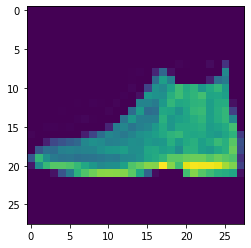

Predicted class: 9, confidence: 99.098%
Actual class: 9 




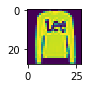

Predicted class: 2, confidence: 99.99%
Actual class: 2 




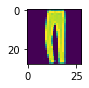

Predicted class: 1, confidence: 100.0%
Actual class: 1 




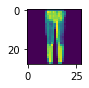

Predicted class: 1, confidence: 100.0%
Actual class: 1 




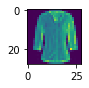

Predicted class: 6, confidence: 92.3%
Actual class: 6 




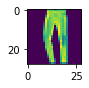

Predicted class: 1, confidence: 99.995%
Actual class: 1 




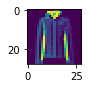

Predicted class: 4, confidence: 98.32%
Actual class: 4 




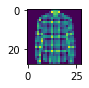

Predicted class: 6, confidence: 93.678%
Actual class: 6 




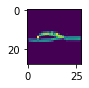

Predicted class: 5, confidence: 99.913%
Actual class: 5 




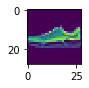

Predicted class: 7, confidence: 99.998%
Actual class: 7 




In [13]:
predictions = estimator.predict(input_fn=input_fn("predict", training=False, batch_size=1))

for i, val in enumerate(predictions):
    predicted_class = val['class_ids'][0]
    prediction_confidence = val['probabilities'][predicted_class] * 100
    
    # Display the image
    plt.imshow(x_test[i])
    plt.rcParams['figure.figsize'] = (1,1)
    plt.show()
    
    print('Predicted class: %s, confidence: %s%%' % (predicted_class, round(prediction_confidence, 3)))
    print('Actual class: %s \n\n' % y_test[i])

## Conclusion and next steps

In this tutorial, you learned how to customize `adanet` to encode your
understanding of a particular dataset, and explore novel search spaces with
AdaNet.

One use-case that has worked for us at Google, has been to take a production
model's TensorFlow code, convert it to into an `adanet.subnetwork.Builder`, and
adaptively grow it into an ensemble. In many cases, this has given significant
performance improvements.

As an exercise, you can swap out the FASHION-MNIST with the MNIST handwritten
digits dataset in this notebook using `tf.keras.datasets.mnist.load_data()`, and
see how `SimpleCNN` performs.